In [23]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
import random
import argparse
from collections import OrderedDict
from copy import copy
import scipy
import scipy.linalg
import sys
sys.path.append("../utility")
sys.path.append("../train")
sys.path.append('../')
from Utility import data_collecter
import lqr
import os
if not os.path.exists("../Prediction_Results/ControlResults/"):
        os.makedirs("../Prediction_Results/ControlResults/")

In [24]:
Methods = ["KoopmanDerivative","KoopmanRBF",\
            "KNonlinear","KNonlinearRNN","KoopmanU",\
            "KoopmanNonlinearA","KoopmanNonlinear",\
            "DKNGU",
                ]
suffixes =["4_28", "4_30", "5_2", "5_2", "5_2", "5_2_ode_constraint"]

In [25]:
method_index = 7
# suffix = "CartPole1_26"
# env_name = "CartPole-v1"
env_name = "LunarLanderContinuous-v2"
# suffix = "Pendulum1_26"
# env_name = "Pendulum-v1"
suffix = suffixes[method_index-2]
# env_name = "DampingPendulum"
# env_name = "DoublePendulum"
# suffix = "MountainCarContinuous1_26"
# env_name = "MountainCarContinuous-v0"

In [26]:
method = Methods[method_index]
root_path = "../Data/"+suffix
print(method)
if method.endswith("KNonlinear"):
    import Learn_Knonlinear as lka
elif method.endswith("KNonlinearRNN"):
    import Learn_Knonlinear_RNN as lka
elif method.endswith("KoopmanNonlinear"):
    import Learn_KoopmanNonlinear_with_KlinearEig as lka
elif method.endswith("KoopmanNonlinearA"):
    import Learn_KoopmanNonlinearA_with_KlinearEig as lka
elif method.endswith("KoopmanU"):
    import Learn_Koopman_with_KlinearEig as lka
elif method.endswith("DKNGU"):
    import Learn_DKN_gxu1 as lka
for file in os.listdir(root_path):
    if file.startswith(method+"_"+env_name) and file.endswith("samples20000.pth"):
        model_path = file  
if method.endswith("DKNGU"):
    for file in os.listdir(root_path):
        if file.startswith(method+"_"+env_name) and file.endswith("bdim2_samples20000_geom0.1_ta.pth"):
            model_path = file
Data_collect = data_collecter(env_name)
udim = Data_collect.udim
Nstate = Data_collect.Nstates
layer_depth = 3
layer_width = 128
dicts = torch.load(root_path+"/"+model_path)
state_dict = dicts["model"]
if method.endswith("KNonlinear"):
    Elayer = dicts["Elayer"]
    net = lka.Network(layers=Elayer,u_dim=udim)
elif method.endswith("KNonlinearRNN"):
    net = lka.Network(input_size=udim+Nstate,output_size=Nstate,hidden_dim=layer_width, n_layers=layer_depth-1)
elif method.endswith("KoopmanNonlinear") or method.endswith("KoopmanNonlinearA"):
    layer = dicts["layer"]
    blayer = dicts["blayer"]
    NKoopman = layer[-1]+Nstate
    net = lka.Network(layer,blayer,NKoopman,udim)
elif method.endswith("KoopmanU"):
    layer = dicts["layer"]
    NKoopman = layer[-1]+Nstate
    net = lka.Network(layer,NKoopman,udim)  
elif method.endswith("DKNGU"):
        state_encode_layers = dicts["Statelayer"]
        control_encode_layers = dicts["Controllayer"]
        NKoopman = control_encode_layers[0]
        # Nkoopman1 = 22
        # control_output_dim = control_encode_layers[0] + control_encode_layers[-1]
        control_output_dim = control_encode_layers[-1]
        net = lka.Network(state_encode_layers, control_encode_layers, NKoopman, udim, control_output_dim, device="cpu")

net.load_state_dict(state_dict)
device = torch.device("cpu")
net.cpu()
net.double()

DKNGU


/tmp/ipykernel_1149327/2194539404.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dicts = torch.load(root_path+"/"+model_path)


Network(
  (state_encoder): Sequential(
    (linear_0): Linear(in_features=8, out_features=128, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=128, out_features=20, bias=True)
  )
  (control_encoder): Sequential(
    (linear_0): Linear(in_features=28, out_features=128, bias=True)
    (relu_0): ReLU()
    (linear_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_1): ReLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): ReLU()
    (linear_3): Linear(in_features=128, out_features=2, bias=True)
  )
  (lA): Linear(in_features=28, out_features=28, bias=False)
  (lB): Linear(in_features=2, out_features=28, bias=False)
)

In [27]:
def Prepare_Region_LQR(env_name,precision = 0.1):
    x_ref = np.zeros(Nstate)
    if env_name.startswith("CartPole"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[1,1] = 0.01
        Q[2,2] = 5.0
        Q[3,3] = 0.01
        R = np.eye(control_output_dim)
        theta_region = np.arange(-2.0,2.0,precision)
        dtheta_region = np.arange(-2.0,2.0,precision)
        reset_state_list = []
        for theta in theta_region:
            for dtheta in dtheta_region:
                reset_state_list.append([0.0,0.0,theta,dtheta])
    elif env_name.startswith("Pendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = np.eye(control_output_dim)
        theta_region = np.arange(-6.0,6.0,precision)
        dtheta_region = np.arange(-6.0,6.0,precision)
        reset_state_list = []
        for theta in theta_region:
            for dtheta in dtheta_region:
                reset_state_list.append([theta,dtheta])
    elif env_name.startswith("DampingPendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 5.0
        R = np.eye(control_output_dim)
        theta_region = np.arange(-4.0,4.0,precision)
        dtheta_region = np.arange(-4.0,4.0,precision)
        reset_state_list = []
        for theta in theta_region:
            for dtheta in dtheta_region:
                reset_state_list.append([theta,dtheta])
    elif env_name.startswith("MountainCarContinuous"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.1
        R = np.eye(control_output_dim)
        x_region = np.arange(-1.2,0.6,precision)
        dx_region = np.arange(-1.0,1.0,precision)
        reset_state_list = []
        for x in x_region:
            for dx in dx_region:
                reset_state_list.append([x,dx])
        x_ref[0] = 0.45
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state_list,x_ref

def Psi_o(s,net): # Evaluates basis functions Ψ(s(t_k))
    psi = np.zeros([NKoopman,1])
    ds = net.encode(torch.DoubleTensor(s)).detach().cpu().numpy()
    psi[:NKoopman,0] = ds
    return psi

def Done(env_name,state):
    if env_name.startswith("CartPole"):
        done = (abs(state[2]) >= np.pi)
    if env_name.startswith("Pendulum"):
        done = (abs(state[0]) >= 2*np.pi)
    if env_name.startswith("DampingPendulum"):
        done = (abs(state[0]) >= 2*np.pi)
    if env_name.startswith("MountainCarContinuous"):
        done = (state[0]>0.7 or state[0]<-1.3)
    return done 

def exp(env,env_name,net,Ad,Bd,Q,R,reset_state,x_ref):
    Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,R)
    observation_list = []
    observation = np.array(env.reset_state(reset_state))
    x0 = np.matrix(Psi_o(observation,net)).reshape(NKoopman,1)
    x_ref_lift = Psi_o(x_ref,net).reshape(NKoopman,1)
    observation_list.append(x0[:Nstate].reshape(-1,1))
    u_list = []
    steps = 200
    flag = False
    for i in range(steps):
        u = -Kopt*(x0-x_ref_lift)
        ureal = u[:udim]
        observation, reward, done, info = env.step(ureal)
        done = Done(env_name,observation)
        if done:
            flag = True
            break
        x0 = np.matrix(Psi_o(observation,net)).reshape(NKoopman,1)
        observation_list.append(x0[:Nstate].reshape(-1,1))
        u_list.append(u)
    u_list = np.array(u_list).reshape(-1)
    observations = np.concatenate(observation_list,axis=1)
    return observations,u_list,flag

def criterion(env_name,observations,flag):
    if flag:
        return 0
    elif env_name.startswith("CartPole"):
        err = np.mean(abs(observations[2:,195:]))
        good = int(err <= 1e-2)
    elif env_name.startswith("Pendulum"):
        err = np.mean(abs(observations[:,195:]))
        good = int(err <= 1e-2)        
    elif env_name.startswith("DampingPendulum"):
        err = np.mean(abs(observations[:,195:]))
        good = int(err <= 1e-2)    
    elif env_name.startswith("MountainCarContinuous"):
        err = np.mean(abs(observations[0,195:]-0.45))+np.mean(abs(observations[1,195:]))
        good = int(err <= 1e-2)      
    return good

def Err(env_name,observations,flag):
    if flag:
        return None
    elif env_name.startswith("CartPole"):
        err = np.mean(abs(observations[2:,195:]))
    elif env_name.startswith("Pendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("DampingPendulum"):
        err = np.mean(abs(observations[:,195:]))
    elif env_name.startswith("MountainCarContinuous"):
        err = np.mean(abs(observations[0,195:]-0.45))+np.mean(abs(observations[1,195:]))
    return err

def Cost(observations,u_list,Q,R,x_ref):
    steps = observations.shape[1]
    loss = 0
    state_dim = x_ref.shape[0]
    for s in range(steps):
        if s!=steps-1:
            ucost = np.dot(np.dot(u_list[s].T,R),u_list[s])
            loss += ucost[0,0]
        xcost = np.dot(np.dot((observations[:,s]-x_ref).T,Q[:state_dim,:state_dim]),(observations[:,s]-x_ref))
        loss += xcost[0,0]
    return loss

In [28]:
# Ad = state_dict['lA.weight'].cpu().numpy()
# Bd = state_dict['lB.weight'].cpu().numpy()
# env = Data_collect.env
# env.reset()
# Ad = np.matrix(Ad)
# Bd = np.matrix(Bd)
# precision = 0.1
# Q,R,reset_state_list,x_ref = Prepare_Region_LQR(env_name,precision=precision)
# for u_val in [0.01,0.01,0.1,1,2,5,10,20,50,100]:
#     print("u_val:", u_val)
#     Errs = {}
#     Costs = {}
#     for reset_state in reset_state_list:
#         obs,u_list,flag = exp(env,env_name,net,Ad,Bd,Q,u_val*R,reset_state,x_ref)
#         err = Err(env_name, obs,flag)
#         Errs[(reset_state[-2],reset_state[-1])] = None
#         if flag:
#             Costs[(reset_state[-2],reset_state[-1])] = None
#         else:
#             cost = Cost(obs,u_list,Q,0.0*R,x_ref)
#             Costs[(reset_state[-2],reset_state[-1])] = cost
            
#     np.savez("../Prediction_Results/ControlResults/"+env_name+"_KoopmanNonlinearA_uval{}.npz".format(u_val),err=Errs,cost=Costs)

In [29]:
# Ad = state_dict['lA.weight'].cpu().numpy()
# Bd = state_dict['lB.weight'].cpu().numpy()
# env = Data_collect.env
# env.reset()
# Ad = np.matrix(Ad)
# Bd = np.matrix(Bd)
# precision = 0.1
# Results_all = {}
# Q,R,reset_state_list,x_ref = Prepare_Region_LQR(env_name,precision=precision)
# for u_val in [0.01,0.1,1,2,5,10,20,50,100]:
#     Results = {}
#     for reset_state in reset_state_list:
#             obs,u_list,flag = exp(env,env_name,net,Ad,Bd,Q,u_val*R,reset_state,x_ref)
#             result = criterion(env_name,obs,flag)
#             Results[(reset_state[-2],reset_state[-1])] = result
#     Results_all[u_val]= Results
#     points = []
#     for key in Results:
#         if Results[key]:
#             points.append(np.array([key[0],key[1]]))
#     points = np.array(points).reshape(-1,2)
#     plt.plot(points[:,0],points[:,1],'r*')
#     plt.savefig("../Prediction_Results/ControlResults/"+env_name+"_KoopmanNonlinearA_saferegion_uval{}.png".format(u_val))
#     plt.show()
#     # print(points.shape)
#     np.save("../Prediction_Results/ControlResults/"+env_name+"_KoopmanNonlinearA_saferegion_uval{}.npy".format(u_val),points)

In [30]:
# points = []
# for key in Results:
#     if Results[key]:
#         points.append(np.array([key[0],key[1]]))
# points = np.array(points).reshape(-1,2)
# plt.plot(points[:,0],points[:,1],'r*')

# plt.savefig("../Prediction_Results/ControlResults/"+env_name+"_KoopmanNonlinearA_saferegion_test.png")
# plt.show()
# # print(points.shape)
# np.save("../Prediction_Results/ControlResults/"+env_name+"_KoopmanNonlinearA_saferegion.npy",points)

In [31]:
def Psi_o(s,net): # Evaluates basis functions Ψ(s(t_k))
    psi = np.zeros([NKoopman,1])
    ds = net.encode(torch.DoubleTensor(s)).detach().cpu().numpy()
    psi[:NKoopman,0] = ds
    return psi

def Prepare_LQR(env_name):
    x_ref = np.zeros(Nstate)
    if env_name.startswith("CartPole"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[1,1] = 0.01
        Q[2,2] = 5.0
        Q[3,3] = 0.01
        Q[4,4] = 0
        R = 0.1*np.eye(1)
        reset_state=  [0.0,0.0,-0.3,0]
    elif env_name.startswith("Pendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 1*np.eye(1)
        reset_state = [-3.0,0.5]
    elif env_name.startswith("DoublePendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 5.0
        Q[2,2] = 0
        Q[3,3] = 0
        R = 1*np.eye(2)
        reset_state = [-1.5, 0.1, 0, 0]
    elif env_name.startswith("DampingPendulum"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 50*np.eye(1)
        reset_state = [-2.5,0.1]   
    elif env_name.startswith("MountainCarContinuous"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 5.0
        Q[1,1] = 0.01
        R = 1*np.eye(1)
        reset_state = [0.5,0.0]  
        x_ref[0] = 0.45
    elif env_name.startswith("LunarLanderContinuous-v2"):
        Q = np.zeros((NKoopman,NKoopman))
        Q[0,0] = 20.0
        Q[1,1] = 20.0
        Q[2,2] = 5.0
        Q[3,3] = 5.0

        R = 100*np.eye(2)
        reset_state = [2.0,0.0]  
        x_ref[0] = 0
        x_ref[1] = 0
        x_ref[-1] = 0
        x_ref[-2] = 0
    Q = np.matrix(Q)
    R = np.matrix(R)
    return Q,R,reset_state,x_ref

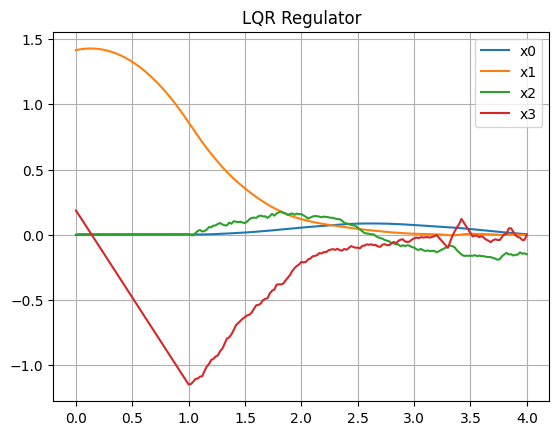

In [32]:
from scipy.linalg import svd
Ad = state_dict['lA.weight'].cpu().numpy()
Bd = state_dict['lB.weight'].cpu().numpy()
env = Data_collect.env
env.reset()
import lqr
import time
Ad = np.matrix(Ad)
Bd = np.matrix(Bd)
Q,R,reset_state,x_ref = Prepare_LQR(env_name)
# Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,R)
Kopt = lqr.lqr_regulator_k(Ad,Bd,Q,R)
observation_list = []
if env_name == "LunarLanderContinuous-v2":
    observation = env.reset()
else:
    observation = env.reset_state(reset_state)
x0 = np.matrix(Psi_o(observation,net))
x_ref_lift = Psi_o(x_ref,net)
observation_list.append(x0[:Nstate].reshape(-1,1))
# print(Kopt)
u_list = []
steps = 200
# umax = 100
for i in range(steps):
    # env.render()
    u = -Kopt*(x0-x_ref_lift)
    gu = net.control_encoder(torch.tensor(x0.T)).detach().numpy()
    if udim == 1:
        ureal = u[0,0]/gu[0,0] 
    else:
        ureal = [u[i,0]/gu[0,i] for i in range(udim)]
    # ureal = u[:udim, 0][0] 
    # print(ureal.shape)
    # u = max(-umax,min(umax,u[0,0]))
    observation, reward, done, info = env.step(ureal)
    x0 = np.matrix(Psi_o(observation,net))
    # x0 = Ad*x0+Bd*u
    observation_list.append(x0[:Nstate].reshape(-1,1))
    u_list.append(u)
    # time.sleep(0.1)

observations = np.concatenate(observation_list,axis=1)
u_list = np.array(u_list).reshape(-1)
time_history = np.arange(steps+1)*env.dt
for i in [0,1,2,3]:
    plt.plot(time_history, observations[i,:].reshape(-1,1), label="x{}".format(i))
plt.grid(True)
plt.title("LQR Regulator")
plt.legend()
plt.show()

测试回合  1/100 | 得分：132.1 | 步数：200 | 落地：(x=0.085, y=0.002)
测试回合  2/100 | 得分：184.4 | 步数：200 | 落地：(x=0.072, y=0.000)
测试回合  3/100 | 得分：106.6 | 步数：200 | 落地：(x=-0.006, y=0.007)
测试回合  4/100 | 得分：108.2 | 步数：200 | 落地：(x=0.001, y=0.002)
测试回合  5/100 | 得分： 51.2 | 步数： 90 | 落地：(x=-0.086, y=-0.038)
测试回合  6/100 | 得分：159.9 | 步数：200 | 落地：(x=-0.021, y=0.000)
测试回合  7/100 | 得分：165.4 | 步数：200 | 落地：(x=-0.204, y=-0.007)
测试回合  8/100 | 得分： 13.3 | 步数： 97 | 落地：(x=0.193, y=-0.035)
测试回合  9/100 | 得分：135.1 | 步数：200 | 落地：(x=-0.013, y=0.001)
测试回合 10/100 | 得分：140.1 | 步数：200 | 落地：(x=-0.022, y=0.001)
测试回合 11/100 | 得分：146.1 | 步数：200 | 落地：(x=-0.047, y=0.004)
测试回合 12/100 | 得分：172.0 | 步数：200 | 落地：(x=-0.116, y=0.002)
测试回合 13/100 | 得分：111.4 | 步数：200 | 落地：(x=-0.026, y=0.007)
测试回合 14/100 | 得分：113.6 | 步数：200 | 落地：(x=0.071, y=0.002)
测试回合 15/100 | 得分： 28.0 | 步数： 76 | 落地：(x=-0.034, y=-0.038)
测试回合 16/100 | 得分：161.7 | 步数：200 | 落地：(x=-0.161, y=-0.009)
测试回合 17/100 | 得分：140.9 | 步数：200 | 落地：(x=0.030, y=0.002)
测试回合 18/100 | 得分：127.0 | 步数：200 

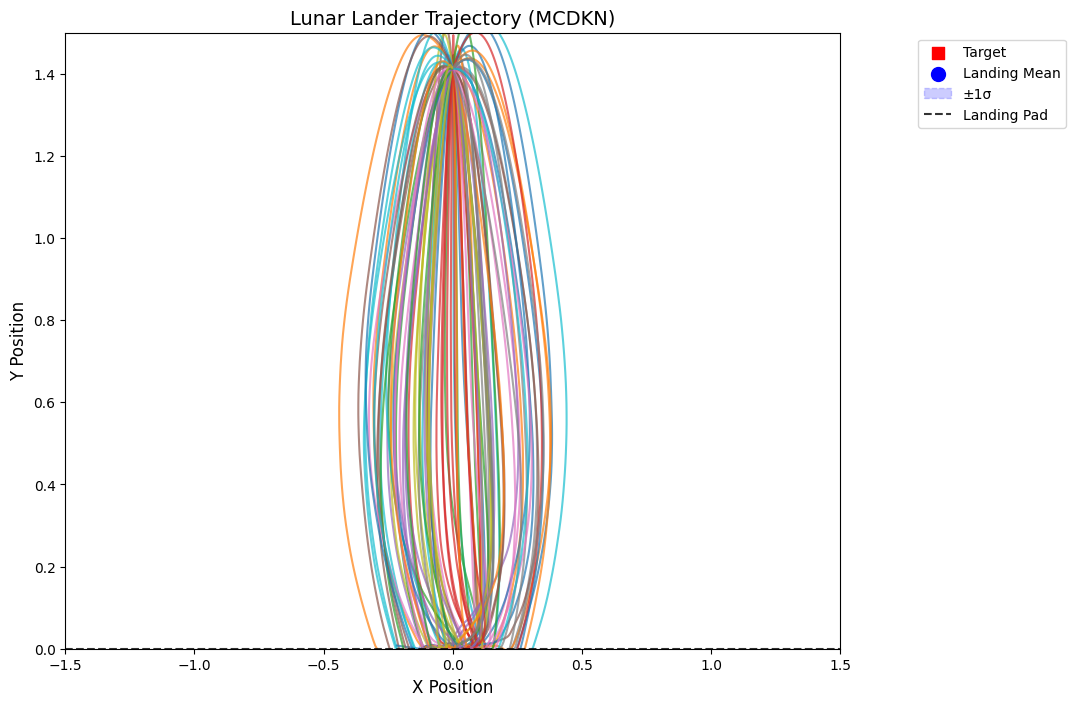


=== 测试总结 ===
平均得分：112.0±62.2 | 成功着陆：100/100


In [33]:
from typing import Tuple, List
def test_lander_lqr(
    net,  # 修正类型：适配DKN_MC2
    K_lqr,
    x_ref,
    num_episodes: int = 100,
    max_steps: int = 200,
    version: str = "MCDKN",
    seed: int = 2022
) -> List[float]:
    # 原函数逻辑不变，仅修正psi类型注解
    env = gym.make("LunarLanderContinuous-v2")
    env.seed(seed)
    device = next(net.parameters()).device
    episode_scores: List[float] = []
    all_trajectories: List[List[Tuple[float, float]]] = []
    landing_positions: List[Tuple[float, float]] = []
    success_count = 0
    net.eval()
    with torch.no_grad():
        for ep in range(num_episodes):
            observation = env.reset()
            done = False
            total_score = 0.0
            step = 0
            trajectory = []
            x0 = np.matrix(Psi_o(observation,net))
            x_ref_lift = Psi_o(x_ref,net)

            while not done and step < max_steps:
                trajectory.append((x0[0,0], x0[1,0]))
                 # env.render()
                u = -K_lqr*(x0-x_ref_lift)
                gu = net.control_encoder(torch.tensor(x0.T)).detach().numpy()
                if udim == 1:
                    ureal = u[0,0]/gu[0,0] 
                else:
                    ureal = [u[i,0]/gu[0,i] for i in range(udim)]
                # ureal = u[:udim, 0][0] 
                # print(ureal.shape)
                # u = max(-umax,min(umax,u[0,0]))
                observation, reward, done, info = env.step(ureal)
                x0 = np.matrix(Psi_o(observation,net))
                # x0 = Ad*x0+Bd*u
                total_score += reward
                step += 1

            landing_x, landing_y = x0[0,0], x0[1,0]
            landing_positions.append((landing_x, landing_y))
            trajectory.append((landing_x, landing_y))
            all_trajectories.append(trajectory)
            episode_scores.append(total_score)
            if abs(landing_x) <= 0.5 and -0.2 <= landing_y <= 0.2:
                success_count += 1
            print(f"测试回合 {ep+1:2d}/{num_episodes} | 得分：{total_score:5.1f} | 步数：{step:3d} | 落地：(x={landing_x:.3f}, y={landing_y:.3f})")

    env.close()
    # 原落地统计与绘图逻辑不变...
    landing_xs = np.array([p[0] for p in landing_positions], dtype=np.float32)
    landing_ys = np.array([p[1] for p in landing_positions], dtype=np.float32)
    mean_x = np.mean(landing_xs)
    mean_y = np.mean(landing_ys)
    var_x = np.var(landing_xs, ddof=1)
    var_y = np.var(landing_ys, ddof=1)
    std_x = np.sqrt(var_x)
    std_y = np.sqrt(var_y)

    print(f"\n=== 落地位置统计 ===")
    x_ref_np = x_ref
    print(f"目标：(x={x_ref_np[0]:.3f}, y={x_ref_np[1]:.3f}) | 均值：(x={mean_x:.3f}, y={mean_y:.3f})")
    print(f"方差：var_x={var_x:.6f}, var_y={var_y:.6f} | 标准差：std_x={std_x:.3f}, std_y={std_y:.3f}")

    # 原轨迹绘图逻辑不变...
    plt.figure(figsize=(10, 8))
    colors = plt.cm.tab10.colors
    for ep, traj in enumerate(all_trajectories):
        x_coords = [p[0] for p in traj]
        y_coords = [p[1] for p in traj]
        plt.plot(x_coords, y_coords, color=colors[ep % len(colors)], alpha=0.7)

    plt.scatter(x_ref_np[0], x_ref_np[1], color="red", marker="s", s=80, label="Target")
    plt.scatter(mean_x, mean_y, color="blue", marker="o", s=100, label=f"Landing Mean")
    plt.gca().add_patch(plt.Rectangle((mean_x-std_x, mean_y-std_y), 2*std_x, 2*std_y, 
                                     color="blue", alpha=0.2, linestyle="--", label="±1σ"))
    plt.axhline(y=0, color="black", linestyle="--", alpha=0.8, label="Landing Pad")
    plt.xlim(-1.5, 1.5)
    plt.ylim(0, 1.5)
    plt.xlabel("X Position", fontsize=12)
    plt.ylabel("Y Position", fontsize=12)
    plt.title(f"Lunar Lander Trajectory ({version})", fontsize=14)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1), fontsize=10)
    plt.show()
    os.makedirs("./fig/lunarlander", exist_ok=True)
    plt.savefig(f"./fig/lunarlander/trajectory_{version}.png", bbox_inches="tight", dpi=300)
    plt.close()

    avg_score = np.mean(episode_scores)
    std_score = np.std(episode_scores)
    print(f"\n=== 测试总结 ===")
    print(f"平均得分：{avg_score:.1f}±{std_score:.1f} | 成功着陆：{success_count}/{num_episodes}")
    return episode_scores

episode_scores = test_lander_lqr(net, Kopt,x_ref)